In [1]:
import sys, os, pickle
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
from collections import Counter
import importlib

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

scriptpath = '..'
sys.path.append(os.path.abspath(scriptpath))

from cadrres import pp, model, evaluation, utility

In [2]:
model_spec_name_list = ['cadrres', 'cadrres-wo-sample-bias', 'cadrres-wo-sample-bias-weight_HNSC']
cv_name = 'cv_pred_226drugs'  # cv_pred | cv_pred_226drugs
gdsc_drug_df = pd.read_csv('../preprocessed_data/GDSC/drug_stat.csv', index_col=0)

# model_spec_name_list = ['cadrres', 'cadrres-wo-sample-bias', 'cadrres-wo-sample-bias-weight']
# gdsc_drug_df = pd.read_csv('../preprocessed_data/GDSC/drug_stat.csv', index_col=0)
# cv_name = 'cv_pred'

output_dir = '../result/{}/'.format(cv_name)
n_fold = 5

In [3]:

gdsc_drug_df.index = gdsc_drug_df.index.astype(str)

gdsc_drug_list = gdsc_drug_df.index

print (gdsc_drug_df.shape)

(226, 27)


In [4]:
gdsc_drug_id_name_dict = dict(zip(gdsc_drug_df.index, gdsc_drug_df['Drug Name'].values))

In [5]:
# selected_drug_ids = ['1032', '1007', '133', '201', '1010', '182', '301', '302', '1012']
# selected_drug_names = ['Afatinib', 'Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib', 'Obatoclax Mesylate', 'PHA-793887', 'PI-103', 'Vorinostat']

In [6]:
drug_log2_max_conc_dict = dict(zip(gdsc_drug_df.index, gdsc_drug_df['log2_max_conc']))
drug_log2_median_ic50_dict = dict(zip(gdsc_drug_df.index, gdsc_drug_df['log2_median_ic50']))

##### Read predictions

In [7]:
output_dict = {}

for model_spec_name in model_spec_name_list:
    
    output_dict[model_spec_name] = []
    
    for k in range(1, n_fold+1):
        pred_dict = pickle.load(open(output_dir + '{}_5f_{}_output_dict.pickle'.format(model_spec_name, k), 'rb'))
        output_dict[model_spec_name].append(pred_dict)

# Compare obs and pred for all validation sets

### For each drug

In [8]:
from sklearn.metrics import f1_score, precision_score, accuracy_score

In [9]:
result_df_list = []

for model_spec_name in model_spec_name_list:
    for k in range(n_fold):
        
        pred_test_df = output_dict[model_spec_name][k]['pred_test_df']
        obs_test_df = output_dict[model_spec_name][k]['obs_test_df']
        
        pred_train_df = output_dict[model_spec_name][k]['pred_train_df']
        obs_train_df = output_dict[model_spec_name][k]['obs_train_df']
        
        drug_list = obs_train_df.columns
        
        results = []
        
        for i, d in enumerate(drug_list):
            
            x = obs_test_df[d].values
            y = pred_test_df[d].values
            sel = ~np.isnan(x)
            
            x = x[sel]
            y = y[sel]
            
            # spearman
            scor, pval = stats.spearmanr(x, y)
            
            # F1 weighted
            x_bool = (x < drug_log2_max_conc_dict[d]).astype(str)
            y_bool = (y < drug_log2_max_conc_dict[d]).astype(str)
            f1 = f1_score(x_bool, y_bool, average='weighted')
            acc = accuracy_score(x_bool, y_bool)
            
            precent_sensitive = (np.sum(x < drug_log2_max_conc_dict[d]) / len(x)) * 100
            
            if precent_sensitive > 0:
                (f1_resistant, f1_sensitive) = f1_score(x_bool, y_bool, average=None)
                (precision1_resistant, precision_sensitive) = precision_score(x_bool, y_bool, average=None)
            else:
                f1_resistant = np.nan
                f1_sensitive = np.nan
                precision1_resistant = np.nan
                precision_sensitive = np.nan
            
            # MAE (sensitive)
            sensitive_sel = x < drug_log2_max_conc_dict[d]
            x_sensitive = x[sensitive_sel]
            y_sensitive = y[sensitive_sel]
            mae = np.mean(np.abs(x_sensitive - y_sensitive))

            # MAE (capped)
            x_capped = np.minimum(x, np.repeat(drug_log2_max_conc_dict[d], len(x)))
            y_capped = np.minimum(y, np.repeat(drug_log2_max_conc_dict[d], len(y)))
            capped_mae = np.mean(np.abs(x_capped - y_capped))
            
            results += [[d, precent_sensitive, drug_log2_max_conc_dict[d], drug_log2_median_ic50_dict[d],
                         scor, pval, acc, f1, f1_resistant, f1_sensitive, precision1_resistant, precision_sensitive, mae, capped_mae]]
            
        result_df = pd.DataFrame(results, columns=['drug_id', 'precent_sensitive', 'log2_max_conc', 'log2_median_ic50', 'spearman', 'pval', 'accuracy', 'F1_weighted', 'F1_resistant', 'F1_sensitive', 'precision1_resistant', 'precision_sensitive', 'MAE_sensitive', 'MAE_capped'])
        result_df.loc[:, 'model'] = model_spec_name
        result_df.loc[:, 'k'] = k+1
        
        result_df_list.append(result_df)
    

In [10]:
all_result_df = pd.concat(result_df_list, axis=0)
all_result_df.loc[:, 'drug_name'] = [gdsc_drug_id_name_dict[d] for d in all_result_df['drug_id']]
all_result_df.head()

,drug_id,precent_sensitive,log2_max_conc,log2_median_ic50,spearman,pval,accuracy,F1_weighted,F1_resistant,F1_sensitive,precision1_resistant,precision_sensitive,MAE_sensitive,MAE_capped,model,k,drug_name
0,1046,17.307692,1.000000,2.948178,0.310006,8.205838e-05,0.762821,0.761041,0.857143,0.301887,0.853846,0.307692,1.759965,0.220294,cadrres,1,681640
1,179,41.208791,5.000000,5.784086,0.484985,3.974912e-12,0.697802,0.700145,0.720812,0.670659,0.788889,0.608696,2.213324,1.116264,cadrres,1,5-Fluorouracil
2,86,77.272727,0.034216,-1.507545,0.085872,4.263190e-01,0.693182,0.684054,0.270270,0.805755,0.294118,0.788732,1.744973,1.699035,cadrres,1,A-443654
3,55,27.272727,2.356144,4.529596,0.099503,3.563358e-01,0.511364,0.534005,0.574257,0.426667,0.783784,0.313725,2.462560,1.372924,cadrres,1,A-770041
4,1032,10.059172,-1.000000,4.760344,0.310738,3.924653e-05,0.887574,0.855081,0.940063,0.095238,0.903030,0.250000,4.750234,0.198610,cadrres,1,Afatinib


In [11]:
all_result_df.to_excel('../result/{}/cv_score.xlsx'.format(cv_name), index=False)

##### Summarize 5-fold

In [12]:
all_result_df.head()

,drug_id,precent_sensitive,log2_max_conc,log2_median_ic50,spearman,pval,accuracy,F1_weighted,F1_resistant,F1_sensitive,precision1_resistant,precision_sensitive,MAE_sensitive,MAE_capped,model,k,drug_name
0,1046,17.307692,1.000000,2.948178,0.310006,8.205838e-05,0.762821,0.761041,0.857143,0.301887,0.853846,0.307692,1.759965,0.220294,cadrres,1,681640
1,179,41.208791,5.000000,5.784086,0.484985,3.974912e-12,0.697802,0.700145,0.720812,0.670659,0.788889,0.608696,2.213324,1.116264,cadrres,1,5-Fluorouracil
2,86,77.272727,0.034216,-1.507545,0.085872,4.263190e-01,0.693182,0.684054,0.270270,0.805755,0.294118,0.788732,1.744973,1.699035,cadrres,1,A-443654
3,55,27.272727,2.356144,4.529596,0.099503,3.563358e-01,0.511364,0.534005,0.574257,0.426667,0.783784,0.313725,2.462560,1.372924,cadrres,1,A-770041
4,1032,10.059172,-1.000000,4.760344,0.310738,3.924653e-05,0.887574,0.855081,0.940063,0.095238,0.903030,0.250000,4.750234,0.198610,cadrres,1,Afatinib


In [13]:
score_df = all_result_df.groupby(by=['drug_id', 'drug_name', 'model']).mean().reset_index().drop(['pval', 'k'], axis=1)
score_df.to_excel('../result/{}/cv_score_summary.xlsx'.format(cv_name), index=False)
score_df.head()

,drug_id,drug_name,model,precent_sensitive,log2_max_conc,log2_median_ic50,spearman,accuracy,F1_weighted,F1_resistant,F1_sensitive,precision1_resistant,precision_sensitive,MAE_sensitive,MAE_capped
0,1,Erlotinib,cadrres,4.495939,1.000000,6.248687,0.288446,0.788192,0.844597,0.878981,0.096923,0.957393,0.063987,3.935780,0.291471
1,1,Erlotinib,cadrres-wo-sample-bias,4.495939,1.000000,6.248687,0.239577,0.926179,0.918103,0.961081,0.000000,0.953547,0.000000,4.822623,0.130414
2,1,Erlotinib,cadrres-wo-sample-bias-weight_HNSC,4.495939,1.000000,6.248687,0.080428,0.955041,0.933176,0.976905,0.000000,0.955041,0.000000,3.188470,0.093213
3,1001,AICA Ribonucleotide,cadrres,54.135582,10.965784,10.861657,0.350585,0.606678,0.577021,0.432622,0.697810,0.630643,0.598018,1.678190,1.339031
4,1001,AICA Ribonucleotide,cadrres-wo-sample-bias,54.135582,10.965784,10.861657,0.359779,0.624099,0.621973,0.570429,0.663553,0.597218,0.643102,0.984353,0.581226


NameError: name 'selected_drug_ids' is not defined

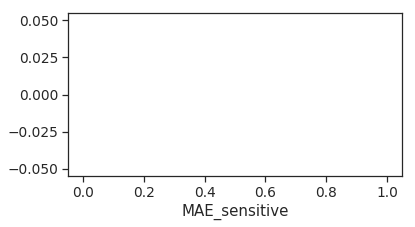

In [14]:
sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(6,3))

score_name = 'MAE_sensitive'

sns.distplot(score_df[score_df['model']=='cadrres-wo-sample-bias-weight'][score_name], kde=False, bins=15)

score_model_df = score_df[score_df['model']=='cadrres-wo-sample-bias-weight']
selected_score_df = score_model_df.loc[score_model_df['drug_id'].isin(selected_drug_ids), ['drug_name', score_name]].sort_values(by=score_name)

for _, row in selected_score_df.iterrows():
    plt.text(row[score_name], 0, row['drug_name'], rotation=45, rotation_mode='anchor', fontsize=10)
    
plt.ylabel("Number of drugs")


NameError: name 'selected_drug_ids' is not defined

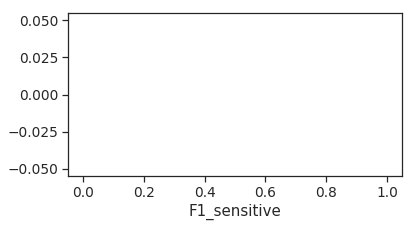

In [15]:
sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(6,3))

score_name = 'F1_sensitive'

sns.distplot(score_df[score_df['model']=='cadrres-wo-sample-bias-weight'][score_name], kde=False, bins=15)

score_model_df = score_df[score_df['model']=='cadrres-wo-sample-bias-weight']
selected_score_df = score_model_df.loc[score_model_df['drug_id'].isin(selected_drug_ids), ['drug_name', score_name]].sort_values(by=score_name)

for _, row in selected_score_df.iterrows():
    plt.text(row[score_name], 0, row['drug_name'], rotation=45, rotation_mode='anchor', fontsize=10)
    
plt.ylabel("Number of drugs")


NameError: name 'selected_drug_ids' is not defined

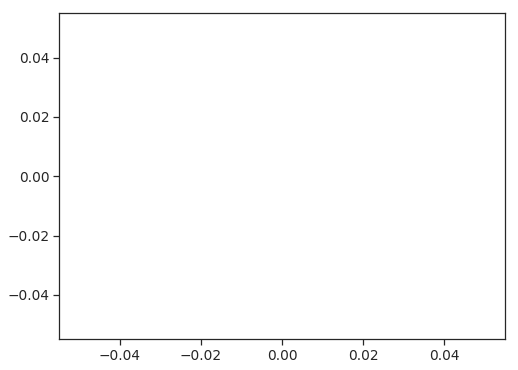

In [16]:
sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data=score_model_df, x='MAE_sensitive', y='F1_sensitive')

for _, row in score_model_df[score_model_df['drug_id'].isin(selected_drug_ids)].iterrows():
    plt.text(row['MAE_sensitive'], row['F1_sensitive'], row['drug_name'], rotation=0, rotation_mode='anchor', fontsize=14)

### For each cell line [TODO]

- identify where in the pharmacological space that the model didn't perform well

In [17]:
result_df_list = []

for model_spec_name in model_spec_name_list:
    for k in range(n_fold):
        
        pred_test_df = output_dict[model_spec_name][k]['pred_test_df'].T
        obs_test_df = output_dict[model_spec_name][k]['obs_test_df'].T
        
#         pred_train_df = output_dict[model_spec_name][k]['pred_train_df']
#         obs_train_df = output_dict[model_spec_name][k]['obs_train_df']
        
        cl_list = pred_test_df.columns
        
        results = []
        
        for u, c in enumerate(cl_list):
            
            x = obs_test_df[c].values
            y = pred_test_df[c].values
            sel = ~np.isnan(x)
            
            x = x[sel]
            y = y[sel]
            
            # spearman
            scor, pval = stats.spearmanr(x, y)
            
##### TODO #####
            
#             # F1 weighted
#             x_bool = (x < drug_log2_max_conc_dict[c]).astype(str)
#             y_bool = (y < drug_log2_max_conc_dict[c]).astype(str)
#             f1 = f1_score(x_bool, y_bool, average='weighted')
#             acc = accuracy_score(x_bool, y_bool)
            
#             precent_sensitive = (np.sum(x < drug_log2_max_conc_dict[d]) / len(x)) * 100
            
#             if precent_sensitive > 0:
#                 (f1_resistant, f1_sensitive) = f1_score(x_bool, y_bool, average=None)
#                 (precision1_resistant, precision_sensitive) = precision_score(x_bool, y_bool, average=None)
#             else:
#                 f1_resistant = np.nan
#                 f1_sensitive = np.nan
#                 precision1_resistant = np.nan
#                 precision_sensitive = np.nan
            
#             # MAE (sensitive)
#             sensitive_sel = x < drug_log2_max_conc_dict[d]
#             x_sensitive = x[sensitive_sel]
#             y_sensitive = y[sensitive_sel]
#             mae = np.mean(np.abs(x_sensitive - y_sensitive))

#             # MAE (capped)
#             x_capped = np.minimum(x, np.repeat(drug_log2_max_conc_dict[d], len(x)))
#             y_capped = np.minimum(y, np.repeat(drug_log2_max_conc_dict[d], len(y)))
#             capped_mae = np.mean(np.abs(x_capped - y_capped))
            
#             results += [[d, precent_sensitive, drug_log2_max_conc_dict[d], drug_log2_median_ic50_dict[d],
#                          scor, pval, acc, f1, f1_resistant, f1_sensitive, precision1_resistant, precision_sensitive, mae, capped_mae]]
            
#         result_df = pd.DataFrame(results, columns=['drug_id', 'precent_sensitive', 'log2_max_conc', 'log2_median_ic50', 'spearman', 'pval', 'accurary', 'F1_weighted', 'F1_resistant', 'F1_sensitive', 'precision1_resistant', 'precision_sensitive', 'MAE_sensitive', 'MAE_capped'])
#         result_df.loc[:, 'model'] = model_spec_name
#         result_df.loc[:, 'k'] = k+1
        
#         result_df_list.append(result_df)